In [5]:
# ! pip install imbalanced-learn
# ! pip install lime
# ! pip install textblob
# ! pip install contractions
# ! pip install spacy
# ! python -m spacy download en_core_web_sm
# ! pip install python-Levenshtein
# ! pip install wordcloud
# ! pip install treeinterpreter

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import pickle 
from imblearn.over_sampling import SMOTE
from collections import Counter
import time

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# from wordcloud import WordCloud
# import lime
# import lime.lime_tabular
# from lime.lime_text import LimeTextExplainer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA, LatentDirichletAllocation

from helpers import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load cleaned data
combine title and body of text 

In [7]:
aita_2 = pd.read_csv('data/aita_save2.csv')
aita = aita_2.dropna(subset=['body_clean', 'title_clean']).loc[(aita_2['score'] >=10) & (aita_2['num_comments']>=10),['body_polarity','body_subjectivity','is_asshole']]
aita['title_body_combo'] =  aita_2['title_clean'] + aita_2['body_clean']
aita.dropna(inplace=True)
aita.reset_index(drop=True, inplace=True)

In [8]:
X = aita.drop('is_asshole', axis=1)
y = aita['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.01, random_state=11)
print(X_train.shape, X_test.shape)
print(Counter(y_train), Counter(y_test))

(46900, 3) (474, 3)
Counter({0: 33859, 1: 13041}) Counter({0: 342, 1: 132})


## 2 - Instantiate CountVectorizer 

In [6]:
# add_stop_words = ['like', 'get', 'go', 'say', 'tell', 'thats', 'want', 'time',
#                   'youre', 'got', 'gonna', 'time', 'also', 'yeah', 'said']
# stop = set(stopwords.words('english')).union(add_stop_words)
# vec = CountVectorizer(stop_words=stop, min_df=0.005, max_df=0.6, ngram_range=(1, 2))
# cv = vec.fit(X_train['title_body_combo'])
# len(cv.get_feature_names())
# # 3204

In [9]:
# pickle.dump(cv, open('models/cv_fit_train_min5.sav', 'wb'))
cv = pickle.load(open('models/cv_fit_train_min5.sav', 'rb'))
len(cv.get_feature_names())
# 3204

3204

### 2.a Transform train and test data into document-term-matrix with CountVectorizer

In [10]:
cv_train = cv.transform(X_train['title_body_combo'])
cv_test = cv.transform(X_test['title_body_combo'])
cv_cols = cv.get_feature_names()
dtm_train = pd.DataFrame(cv_train.toarray(), columns=cv_cols, index=X_train.index)
dtm_test = pd.DataFrame(cv_test.toarray(), columns=cv_cols, index=X_test.index)

In [11]:
dtm_train.shape, dtm_test.shape

((46900, 3204), (474, 3204))

## 3 - PCA

In [21]:
# pca = IncrementalPCA(n_components=1000, batch_size=1050)
# pca.fit(dtm_train)
# print(pca.explained_variance_ratio_.sum())

0.8858948258154675


In [22]:
# pickle.dump(pca, open('models/pca_min10.sav', 'wb'))
# # pca = pickle.load(open('models/pca_min10.sav', 'rb'))
# print(pca.get_params)
# print(pca.explained_variance_ratio_.sum())
# # 0.8858948258154675

<bound method BaseEstimator.get_params of IncrementalPCA(batch_size=1050, n_components=1000)>
0.8858948258154675


#### 3.a Scree plot, check number of components is appropriate

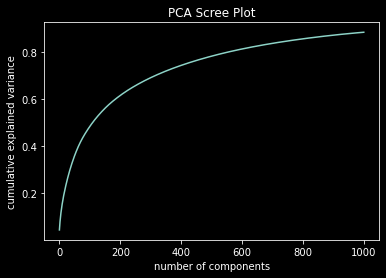

In [23]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.title('PCA Scree Plot')
# evr = pca.explained_variance_ratio_
# cvr = np.cumsum(pca.explained_variance_ratio_)
# pca_df = pd.DataFrame()
# pca_df['Cumulative Variance Ratio'] = cvr
# pca_df['Explained Variance Ratio'] = evr

### 3.b - Transform train/test Document-Term-matrix with PCA

In [24]:
# dtm_train_pca = pca.transform(dtm_train)
# dtm_test_pca = pca.transform(dtm_test)

In [25]:
# # Build DataFrame of PCA Components
# col_names = ['PC_' + str(i) for i in range(1, pca.get_params()['n_components']+1)]
# dtm_train_pca_df = pd.DataFrame(dtm_train_pca, columns=col_names, index=dtm_train.index)
# dtm_test_pca_df = pd.DataFrame(dtm_test_pca, columns=col_names, index=dtm_test.index)

In [26]:
# # Combine PCA components and sentiment analysis scores into one DataFrame
# X_train_post_dtm_pca = pd.concat([X_train[['body_polarity','body_subjectivity']], dtm_train_pca_df], axis=1)
# X_test_post_dtm_pca = pd.concat([X_test[['body_polarity','body_subjectivity']],dtm_test_pca_df], axis=1)

## 4 Oversample minority class with SMOTE

In [29]:
# # sentiment analysis + PCA
# X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_post_dtm_pca, y_train)
# X_test_smote, y_test_smote = SMOTE().fit_resample(X_test_post_dtm_pca, y_test)
# Counter(y_train_smote), Counter(y_test_smote)

(Counter({1: 16571, 0: 16571}), Counter({1: 168, 0: 168}))

In [12]:
# DTM 
X_train_dtm_smote, y_train_smote = SMOTE().fit_resample(dtm_train, y_train)
X_test_dtm_smote, y_test_smote = SMOTE().fit_resample(dtm_test, y_test)

In [13]:
# sentiment analysis + DTM
X_train_dtm_sen = pd.concat([X_train[['body_polarity','body_subjectivity']], dtm_train], axis=1)
X_test_dtm_sen = pd.concat([X_test[['body_polarity','body_subjectivity']], dtm_test], axis=1)
X_train_dtm_sen_smote, y_train_smote = SMOTE().fit_resample(X_train_dtm_sen, y_train)
X_test_dtm_sen_smote, y_test_smote = SMOTE().fit_resample(X_test_dtm_sen, y_test)

# Models

In [14]:
n=.3

## 1 - Logistic Regression

#### LR with DTM and Sentiment Analysis

In [113]:
lr_dtm_sen = LogisticRegression(max_iter=800, penalty='l2', solver='lbfgs')
lr_dtm_sen.fit(X_train_dtm_sen_smote, y_train_smote)
dtm_sen_model = lr_dtm_sen                        
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

train smote
F1 Score = 0.805
Accuracy Score = 0.804
test smote
F1 Score = 0.754
Accuracy Score = 0.753
train no smote
F1 Score = 0.498
Accuracy Score = 0.718
test no smote
F1 Score = 0.394
Accuracy Score = 0.655


In [37]:
lr_dtm_sen = LogisticRegression(max_iter=800, penalty='l2', solver='lbfgs')
cross_scores_f1 = cross_val_score(lr_dtm_sen,X_train_dtm_sen_smote,y_train_smote,scoring='f1')
cross_scores_acc = cross_val_score(lr_dtm_sen,X_train_dtm_sen_smote,y_train_smote,scoring='accuracy')
print(cross_scores_f1)
print(f'average f1 = {cross_scores_f1.mean()}')
print(cross_scores_acc)
print(f'average accuracy = {cross_scores_acc.mean()}')

[0.38787151 0.44425419 0.86402864 0.86132688 0.86737707]
average f1 = 0.6849716572862538
[0.5483609  0.56866509 0.84295629 0.83917891 0.84744887]
average accuracy = 0.7293220116328735


## 2 - Random Forest Model

In [17]:
# cross validation 
rfc_sen = RandomForestClassifier(n_jobs=-1, min_samples_split=5,random_state=20)
cross_scores_f1 = cross_val_score(rfc_sen,X_train_dtm_sen_smote,y_train_smote,scoring='f1')
cross_scores_acc = cross_val_score(rfc_sen,X_train_dtm_sen_smote,y_train_smote,scoring='accuracy')
print(cross_scores_f1)
print(f'average f1 = {cross_scores_f1.mean()}')
print(cross_scores_acc)
print(f'average accuracy = {cross_scores_acc.mean()}')

[0.24083029 0.32417337 0.91874475 0.91491296 0.91722156]
average f1 = 0.6631765835330967
[0.52753987 0.55463674 0.91516539 0.90570775 0.90976888]
average accuracy = 0.7625637252898699


In [33]:
start = time.time()
rfc_sen = RandomForestClassifier(n_jobs=-1,min_samples_split=3, random_state=20)
rfc_sen.fit(X_train_dtm_sen_smote, y_train_smote)
end = time.time()
print((end-start)/60)
dtm_sen_model = rfc_sen                        
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

0.23870397011439007
smote train : F1 Score = 1.000
smote train : Accuracy Score = 1.000
smote test : F1 Score = 0.742
smote test : Accuracy Score = 0.775
no smote train : F1 Score = 1.000
no smote train : Accuracy Score = 1.000
no smote test : F1 Score = 0.254
no smote test : Accuracy Score = 0.703


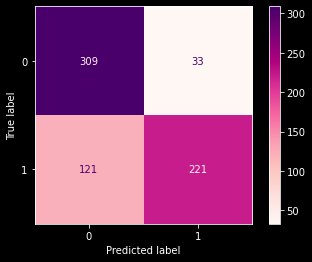

In [34]:
plot_confusion_matrix(rfc_sen, X_test_dtm_sen_smote, y_test_smote, cmap='RdPu');
plt.savefig('image/rfc_sen_conf_matrix.png')

In [106]:
# pickle.dump(rfc_sen, open('models/rfc_sen.sav', 'wb'))

## 4 - Support Vector Machines (SVM)

In [18]:
# cross validation 
SGD_sen = SGDClassifier()
cross_scores_f1 = cross_val_score(SGD_sen,X_train_dtm_sen_smote,y_train_smote,scoring='f1')
cross_scores_acc = cross_val_score(SGD_sen,X_train_dtm_sen_smote,y_train_smote,scoring='accuracy')
print(cross_scores_f1)
print(f'average f1 = {cross_scores_f1.mean()}')
print(cross_scores_acc)
print(f'average accuracy = {cross_scores_acc.mean()}')

[0.35379289 0.44417038 0.87392438 0.83623693 0.91283042]
average f1 = 0.6841910012537974
[0.54274956 0.55899291 0.84775546 0.86133058 0.8399173 ]
average accuracy = 0.7301491619592015


In [28]:
start = time.time()
SGD_sen = SGDClassifier()
SGD_sen.fit(X_train_dtm_sen_smote, y_train_smote)
end = time.time()
print((end-start)/60)
dtm_sen_model = SGD_sen                        
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

0.8240721503893534
smote train : F1 Score = 0.786
smote train : Accuracy Score = 0.788
smote test : F1 Score = 0.737
smote test : Accuracy Score = 0.740
no smote train : F1 Score = 0.445
no smote train : Accuracy Score = 0.697
no smote test : F1 Score = 0.342
no smote test : Accuracy Score = 0.635


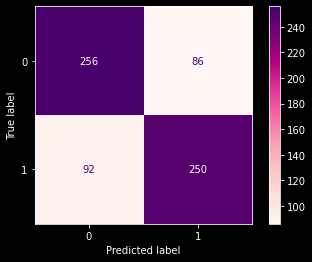

In [31]:
plot_confusion_matrix(SGD_sen, X_test_dtm_sen_smote, y_test_smote,cmap='RdPu')
plt.savefig('image/sgd_sen_conf_matrix.png')

# Testing

In [25]:
aita_clean = pd.read_csv('data/aita_clean.csv')

In [26]:
tops = aita_clean[['title','body','verdict','is_asshole','score']].sort_values('score', ascending=False).head(500)

In [32]:
diag_tops = Proctologist(model=SGD_sen, sentiment=True, cv=cv).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.732

In [36]:
diag_tops = Proctologist(model=rfc_sen, sentiment=True, cv=cv).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.996

In [181]:
diag_tops = Proctologist(model=lr_dtm_sen, sentiment=True).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.686

## Testing with fake conflict

Random Forest with sentiment

In [42]:
texts=["""
my mom pushed me off a cliff after I said I will not buy her a playstation 5. I'm now half dead and will never walk again, my whole family is mad at me for not buying her the playstation 5, aita?"""]
true_verdict = [1]

SGD without sentiment

In [43]:
diag = Proctologist(model=SGD_sen, sentiment=True, cv=cv).diagnosis(texts)
diag['true_verdict'] = true_verdict
diag['correct_prediction'] = diag['true_verdict'] == diag['asshole']
# sum(diag.correct_prediction)/len(diag.correct_prediction)
diag

,text,asshole,true_verdict,correct_prediction
0,\nmy mom pushed me off a cliff after I said I ...,1,1,True


In [44]:
diag_rfc = Proctologist(model=rfc_sen, sentiment=True, cv=cv).diagnosis(texts)
diag_rfc['true_verdict'] = true_verdict
diag_rfc['correct_prediction'] = diag_rfc['true_verdict'] == diag_rfc['asshole']
diag_rfc

,text,asshole,true_verdict,correct_prediction
0,\nmy mom pushed me off a cliff after I said I ...,1,1,True
